# De-biasing Classifiers with Themis-ml

**Tutorial FAT* Conference 2018**

*Author: Niels Bantilan*

*Email: niels.bantilan@gmail.com*

*Created on: 1/29/2018*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#De-biasing-Classifiers-with-Themis-ml" data-toc-modified-id="De-biasing-Classifiers-with-Themis-ml-1">De-biasing Classifiers with Themis-ml</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2">Background</a></span></li><li><span><a href="#Outline" data-toc-modified-id="Outline-3">Outline</a></span></li><li><span><a href="#Installation" data-toc-modified-id="Installation-4">Installation</a></span></li><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-5">Load Dataset</a></span></li><li><span><a href="#Measuring-Potential-Discrimination" data-toc-modified-id="Measuring-Potential-Discrimination-6">Measuring Potential Discrimination</a></span></li><li><span><a href="#De-biasing-Experiment" data-toc-modified-id="De-biasing-Experiment-7">De-biasing Experiment</a></span><ul class="toc-item"><li><span><a href="#Reject-Option-Classification" data-toc-modified-id="Reject-Option-Classification-7.1">Reject-Option Classification</a></span></li><li><span><a href="#Additive-Counterfactually-Fair-Model" data-toc-modified-id="Additive-Counterfactually-Fair-Model-7.2">Additive Counterfactually Fair Model</a></span></li></ul></li><li><span><a href="#The-Fairness-utility-Tradeoff" data-toc-modified-id="The-Fairness-utility-Tradeoff-8">The Fairness-utility Tradeoff</a></span></li><li><span><a href="#Using-Your-Own-Dataset" data-toc-modified-id="Using-Your-Own-Dataset-9">Using Your Own Dataset</a></span></li><li><span><a href="#References" data-toc-modified-id="References-10">References</a></span></li></ul></div>

# Background

Decision support systems (DSS) are information systems that help people make decisions in a particular context like medical diagnosis, loan-granting, and hiring. DSSs have traditionally been built on expert-derived rules-based methods, but as machine learning (ML) is integrated into these systems, we need better tools to measure and mitigate discriminatory patterns in both training data and the predictions made by ML models.

This tutorial introduces [themis-ml](https://github.com/cosmicBboy/themis-ml) [1], an open source Python library for measuring and reducing **potential discrimination** (PD) in machine learning systems.

At a high level, themis-ml defines discrimination as something that occurs when an action is based on biases that systematically benefits one group of people over another based on certain social attributes (legally known as protected classes such as race, gender, and religion).

In the machine learning context, this means that an ML model is discriminatory if it generates predictions that systematically benefits one social group over another. Themis-ml builds on the [sklearn API](http://scikit-learn.org/stable/) [2] to provide a **fairness-aware machine learning interface** (FMLI), which defines an interface that incorporates discrimination discovery and fairness-aware methods into a typical ML workflow.

You find the origin source code for this document [here](https://github.com/cosmicBboy/themis-ml/tree/master/examples).

# Outline

In this tutorial we'll use the [German Credit Dataset](https://archive.ics.uci.edu/ml/datasets/statlog+%28german+credit+data%29) to build
intuition around the a few of the main concepts around discrimination discovery and
fairness-aware machine learning. Specifically, this tutorial will go over how to:

1. Measure potential discrimination with respect to the target variable `credit risk`
   and two socially sensitive attributes `sex` and `foreigner`.
2. Compare a set of classifiers with the fairness-aware `estimators` provided by
   themis-ml with a baseline fairness-unaware model.
3. Assess the fairness-utility tradeoff based on the experimental results we found
   in *step 2*.

# Installation

Currently Python 2.7 and 3.6 are supported. You can use conda or pip to install themis-ml.

```
pip install themis-ml
```

It's highly recommended that you use conda. To install conda, follow the
[instructions here](https://conda.io/docs/user-guide/install/index.html).

```
# create virtual environment
conda create -n themis-ml python=<version>  # <version> = 2.7 or 3.6

# install themis-ml
conda install -c cosmicbboy themis-ml
```

# Load Dataset

`themis-ml` provides a convenience function for loading the German Credit Dataset:

In [1]:
from themis_ml.datasets import german_credit

raw_data = german_credit(raw=True)
raw_data.head()

,status_of_existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account/bonds,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,other_debtors/guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker,credit_risk
0,1,6,critical_account/other_credits_existing_not_at...,radio/television,1169,0,4,4,male_single,none,...,real_estate,67,none,own,2,2,1,1,1,1
1,2,48,existing_credits_paid_back_duly_till_now,radio/television,5951,1,2,2,female_divorced/separated/married,none,...,real_estate,22,none,own,1,2,1,0,1,0
2,0,12,critical_account/other_credits_existing_not_at...,education,2096,1,3,2,male_single,none,...,real_estate,49,none,own,1,1,2,0,1,1
3,1,42,existing_credits_paid_back_duly_till_now,furniture/equipment,7882,1,3,2,male_single,guarantor,...,building_society_savings_agreement/life_insurance,45,none,for free,1,2,2,0,1,1
4,1,24,delay_in_paying_off_in_the_past,car_(new),4870,1,2,3,male_single,none,...,unknown/no_property,53,none,for free,2,2,2,0,1,0


# Measuring Potential Discrimination

For the purposes of this tutorial, we'll use **mean difference** as our measure
of potential discrimination with respect to a binary target variable **credit risk**
and two protected classes **sex** and **immigration status**.

This metric belongs to a class of group-level discrimination measures that captures
differences in outcome between populations, e.g. `female` vs. `male` [3]. In contrast,
individual-level measures capture differences in outcome between an individual and
a set of similar peers, where similarity is formalized as some distance function
parameterized by the feature space.

The assumptions that we'll make in measuring PD in this exercise are the
following:

1. The target $y \in \{0, 1\}$ is binary variable where $y^+ = 1$ is a beneficial
   outcome (e.g. low credit risk) and $y^- = 0$ is a harmful outcome (e.g. high
   credit risk)
2. The protected attribute $s \in \{d, a\}$ is a binary variable
   where $d = 1$ is some putatively disadvantaged group and $a = 0$ is an advantaged
   group.

In [2]:
from themis_ml.metrics import mean_difference

# target variable
# values: 1 = low credit risk, 0 = high credit risk
credit_risk = raw_data["credit_risk"]

# display frequency counts of each value
credit_risk.value_counts()

1    700
0    300
Name: credit_risk, dtype: int64

In [3]:
# get sex of the individual from the "personal_status_and_sex" column.
# values: 1 = female, 0 = male
sex = raw_data["personal_status_and_sex"].map(
    lambda x: {"male": 0, "female": 1}[x.split("_")[0]])

# display frequency counts of each value
sex.value_counts()

0    690
1    310
Name: personal_status_and_sex, dtype: int64

In [4]:
# get foreign worker status: 1 = yes, 0 = no
foreign = raw_data["foreign_worker"]

# display frequency counts of each value
foreign.value_counts()

1    963
0     37
Name: foreign_worker, dtype: int64

In [5]:
print("Mean difference scores:")
print("protected class = sex: %0.03f, 95%% CI [%0.03f-%0.03f]" %
      mean_difference(credit_risk, sex))
# 0.0748013090229
print("protected class = foreign: %0.03f, 95%% CI [%0.03f-%0.03f]" %
      mean_difference(credit_risk, foreign))
# 0.199264685246

Mean difference scores:
protected class = sex: 0.075, 95% CI [0.013-0.136]
protected class = foreign: 0.199, 95% CI [0.049-0.349]


The mean differences above suggest that men and citizen workers are
more likely to have low credit risks compared to women and foreign workers,
respectively.

The `themis-ml` metrics functions compute confidence intervals by default,
since it's important to come up with confidence bounds for our estimate
of potential discrimination.

# De-biasing Experiment

In this experiment, we specify three conditions, all using `LogisticRegression`
as the classifier to keep things simple:

1. **Baseline** ($B$): classifier trained on all available input variables,
   including protected attributes.
2. **Remove Protected Attribute** ($RPA$): classifier where input variables do
   not contain protected attributes. This is the naive fairness-aware
   approach.
3. **Reject-Option Classification** ($ROC$): classifier using the reject-option
   classification method.
4. **Additive Counterfactually Fair Model** ($ACF$): classifier using the additive
   counterfactually fair method.
   
In this toy example, we'll be using `mean_difference` as our "fairness" metric,
and area under the curve `auc` as our "utility" metric.
   
## Reject-Option Classification

ROC works by training an initial classifier on your dataset $D$, generating
predicted probabilities on the test set, and then computing the proximity of
each prediction to the decision boundary learned by the classifier [5].

Within this boundary defined by the critical region threshold $\theta$,
where $0.5 < \theta < 1$, $X_d$ are assigned a label $y = 1$ and $X_a$
are assigned as $y = 0$, where $X_d$ are disadvantaged observations
and $X_a$ are advantaged observations.

## Additive Counterfactually Fair Model

ACF, as described by [6] within the framework of counterfactual fairness, is
the idea that we model the correlations between $s$ and features in $X$ by
training linear models to predict each feature $X_j$ using $s$ as input.

Then, we can compute the residuals $\epsilon_{ij}$ between predicted and true
feature values for each observation $i$ and feature $j$. The final model is
then trained on $\epsilon_{ij}$ as features to predict $y$.

Before training our models, we first need to set up our experiment harness,
which includes the features sets, inputs $X$, output $y$, and protected
attributes $s_{sex}$ and $s_{foreigner}$.

Here we'll use 5-fold, 20x [`RepeatedStratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html)
in order to obtain a better estimate of test performance and fairness.

In [6]:
from sklearn.model_selection import train_test_split

# load model-ready data
training_data = german_credit()
training_data.head()

# define feature sets:
# 1. including protected attributes
features = [
    'duration_in_month', 'credit_amount', 'installment_rate_in_percentage_of_disposable_income',
    'present_residence_since', 'age_in_years', 'number_of_existing_credits_at_this_bank',
    'number_of_people_being_liable_to_provide_maintenance_for', 'status_of_existing_checking_account',
    'savings_account/bonds', 'present_employment_since', 'job', 'telephone', 'foreign_worker',
    'credit_history_all_credits_at_this_bank_paid_back_duly',
    'credit_history_critical_account/other_credits_existing_not_at_this_bank',
    'credit_history_delay_in_paying_off_in_the_past', 'credit_history_existing_credits_paid_back_duly_till_now',
    'credit_history_no_credits_taken/all_credits_paid_back_duly', 'purpose_business',
    'purpose_car_(new)', 'purpose_car_(used)', 'purpose_domestic_appliances', 'purpose_education',
    'purpose_furniture/equipment', 'purpose_others', 'purpose_radio/television',
    'purpose_repairs', 'purpose_retraining', 'personal_status_and_sex_female_divorced/separated/married',
    'personal_status_and_sex_male_divorced/separated', 'personal_status_and_sex_male_married/widowed',
    'personal_status_and_sex_male_single', 'other_debtors/guarantors_co-applicant',
    'other_debtors/guarantors_guarantor', 'other_debtors/guarantors_none',
    'property_building_society_savings_agreement/life_insurance',
    'property_car_or_other', 'property_real_estate', 'property_unknown/no_property',
    'other_installment_plans_bank', 'other_installment_plans_none',
    'other_installment_plans_stores', 'housing_for free', 'housing_own', 'housing_rent',
]
# 2. removing variables related to sex
features_no_sex = [
    f for f in features if f not in [
        'personal_status_and_sex_female_divorced/separated/married',
        'personal_status_and_sex_male_divorced/separated',
        'personal_status_and_sex_male_married/widowed',
        'personal_status_and_sex_male_single']]

# 3. removing variables related to immigration status
features_no_frn = [f for f in features if f != "foreign_worker"]

X = training_data[features].values
X_no_sex = training_data[features_no_sex].values
X_no_frn = training_data[features_no_frn].values
y = training_data["credit_risk"].values
s_sex = sex.values
s_frn = foreign.values

Now we're ready to train our models.

In [12]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone

from themis_ml.postprocessing.reject_option_classification import \
    SingleROClassifier
from themis_ml.linear_model import LinearACFClassifier

METRICS_COLUMNS = [
    "mean_diff_sex", "mean_diff_foreign", "auc_sex", "auc_foreign"]


def run_experiment_iteration(
        X, X_no_sex, X_no_frn, y, s_sex, s_frn, train, test):
    """Run the experiment on a particular set of train and test indices."""
    
    # store our metrics here. This will be a list of lists, where the inner
    # list is contains the following metadata:
    # - "name"
    # - fairness metric with respect to sex
    # - fairness metric with respect to foreign status
    # - utility metric with respect to sex
    # - utility metric with respect to foreign status
    metrics = []

    # define our model.
    logistic_clf = LogisticRegression(penalty="l2", C=0.001, class_weight="balanced")
    baseline_clf = logistic_clf
    rpa_clf = logistic_clf
    roc_clf = SingleROClassifier(estimator=logistic_clf)
    acf_clf = LinearACFClassifier(
        target_estimator=logistic_clf,
        binary_residual_type="absolute")

    # train baseline model
    baseline_clf.fit(X[train], y[train])
    baseline_preds = baseline_clf.predict(X[test])
    baseline_auc = roc_auc_score(y[test], baseline_preds)
    metrics.append([
        "B",
        mean_difference(baseline_preds, s_sex[test])[0],
        mean_difference(baseline_preds, s_frn[test])[0],
        baseline_auc, baseline_auc  # repeated because the two AUC values are the
                                    # same in the baseline case
    ])

    # train "remove protected attributes" model. Here we have to train two
    # seperate ones for sex and foreign status.

    # model trained with no explicitly sex-related variables
    rpa_preds_no_sex = rpa_clf.fit(
        X_no_sex[train], y[train]).predict(X_no_sex[test])
    # model trained with no explicitly foreign-related variables
    rpa_preds_no_frn = rpa_clf.fit(
        X_no_frn[train], y[train]).predict(X_no_frn[test])
    metrics.append([
        "RPA",
        mean_difference(rpa_preds_no_sex, s_sex[test])[0],
        mean_difference(rpa_preds_no_frn, s_frn[test])[0],
        roc_auc_score(y[test], rpa_preds_no_sex),
        roc_auc_score(y[test], rpa_preds_no_frn),
    ])

    # train reject-option classification model.
    roc_clf.fit(X[train], y[train])
    roc_preds_sex = roc_clf.predict(X[test], s_sex[test])
    roc_preds_frn = roc_clf.predict(X[test], s_frn[test])
    metrics.append([
        "ROC",
        mean_difference(roc_preds_sex, s_sex[test])[0],
        mean_difference(roc_preds_frn, s_frn[test])[0],
        roc_auc_score(y[test], roc_preds_sex),
        roc_auc_score(y[test], roc_preds_frn),
    ])

    # train additive counterfactually fair model.
    acf_preds_sex = acf_clf.fit(
        X[train], y[train], s_sex[train]).predict(X[test], s_sex[test])
    acf_preds_frn = acf_clf.fit(
        X[train], y[train], s_frn[train]).predict(X[test], s_frn[test])
    metrics.append([
        "ACF",
        mean_difference(acf_preds_sex, s_sex[test])[0],
        mean_difference(acf_preds_frn, s_frn[test])[0],
        roc_auc_score(y[test], acf_preds_sex),
        roc_auc_score(y[test], acf_preds_frn),
    ])

    # convert metrics list of lists into dataframe
    return pd.DataFrame(
        metrics, columns=["condition"] + METRICS_COLUMNS)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

N_SPLITS = 5
N_REPEATS = 20

# add these two binary variables so that we can stratify the observations
# by protected class
groups = np.add(s_sex, s_frn)

# do 5-fold, 10x repeating cross validation so that we quantify the
# uncertainty around our metrics estimates.
cv = RepeatedStratifiedKFold(
    n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=41)

metrics = []
print("Running cross-validation experiment...")
for i, (train_idx, test_idx) in enumerate(cv.split(X, y, groups=groups)):
    metrics.append(
        run_experiment_iteration(
            X, X_no_sex, X_no_frn, y, s_sex, s_frn, train_idx, test_idx)
        .assign(rep_fold=i))

# concatenate metrics from all cv-folds
metrics = pd.concat(metrics)

# compute mean point estimate for each metric and each condition
group_df = metrics.groupby("condition")
mean_metrics = (
    group_df
    [METRICS_COLUMNS].mean()
)
# compute standard error of the mean
stderr_metrics = (
    group_df
    [METRICS_COLUMNS].std()
) / np.sqrt(N_REPEATS * N_SPLITS)

Running cross-validation experiment...


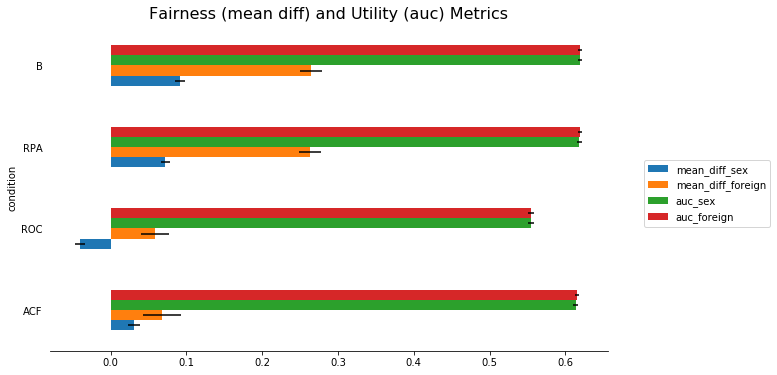

In [17]:
# plot vertical bar chart
ax = mean_metrics.loc[reversed(["B", "RPA", "ROC", "ACF"])].plot(
    kind="barh", figsize=(10, 6),
    xerr=stderr_metrics.loc[reversed(["B", "RPA", "ROC", "ACF"])],
    legend=False);
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 0.6))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='y', which='both', left='off')
ax.set_title(
    "Fairness (mean diff) and Utility (auc) Metrics", fontsize=16);

In [20]:
mean_metrics.loc[["B", "RPA", "ROC", "ACF"]].rename(
    columns=lambda x: "mean(%s)" % x)

,mean(mean_diff_sex),mean(mean_diff_foreign),mean(auc_sex),mean(auc_foreign)
condition,,,,
B,0.091543,0.264124,0.619131,0.619131
RPA,0.072296,0.263176,0.618202,0.619060
ROC,-0.040102,0.058324,0.554310,0.554310
ACF,0.030862,0.067540,0.613583,0.615202


# The Fairness-utility Tradeoff

We'll conclude this tutorial by interpreting the results in the de-biasing
experiment we just ran.

In the plot that we just made, we can note a few interesting things:

1. Removing the $s_{sex}$ protected attribute (RPA) decreases `mean difference` by
   roughly 2% points compared to baseline (B), mean `auc` are approximately 
   the same between the two conditions.
1. There is no reduction in `mean difference` when removing the $s_{foreigner}$
   variable (RPA) compared to baseline (B), highlighting the fact that the naive
   fairness-aware approach of removing sensitive attributes doesn't necessarily
   result in a fairer model.
1. The reject-option classification (ROC) model lead to a marked reduction in
   `mean difference` compared to baseline (~13% points for $s_{sex}$ and ~20% points
   for $s_{foreigner}$, meaning that the prediction made by these models reduce
   potential discrimination, but at the cost of about 5% points of `auc`.
1. Note that in the case of ROC, we get a negative `mean difference` with respect to
   $s_{sex}$,  meaning that we're actually now slightly favoring women over men
   when predicting the beneficial `low credit risk` outcome.
1. In the additive counterfactually fair (ACF) model, we see a ~6% point reduction
   in `mean difference` with respect to $s_{sex}$ and a ~19% point reduction
   with respect to $s_{foreigner}$. However, unlike ROC, we maintain an `auc` of
   about 61%, even though we're making fairer predictions.
   
These observations highlight the fact that with certain methods like ROC, we
see evidence of the fairness-utility tradeoff, but with others, like ACF,
it's possible to produce a model that reduces potential discrimination in the
predictions while preserving its utility with respect to some measure of
predictive power (in this case, `auc`).

# Using Your Own Dataset

`themis-ml` is designed to be a flexible tool for measuring and reducing potential discrimination in the supervised learning setting for classification tasks in any arbitrary dataset. Future development will add support for fairness-aware regression estimators, as well as other cases such as multi-class classification and multi-valued protected class attributes.

You can read in your data as a `pandas.DataFrame` or `numpy.array`, and you should be able to use the `Estimator` and `Scorer` APIs as you just did with the German Credit dataset.

In this exercise, you looked at a fairly simplistic example of how one might de-bias a classifier, but clearly
the real world is much more complicated, so if you'd like to contribute to this project, please feel free to submit issues in the [github repo](https://github.com/cosmicBboy/themis-ml/issues), and pull requests are welcome!

# References

1. Bantilan, Niels. "Themis-ml: A Fairness-aware Machine Learning Interface for End-to-end Discrimination
   Discovery and Mitigation." arXiv preprint arXiv:1710.06921 (2017).
2. Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python."
   Journal of Machine Learning Research 12. Oct (2011): 2825-2830.
3. Zliobaite, Indre. "A survey on measuring indirect discrimination in machine learning."
   arXiv preprint arXiv:1511.00148 (2015).
4. Kamishima, Toshihiro, et al. "Fairness-aware classifier with prejudice remover regularizer."
   Machine Learning and Knowledge Discovery in Databases (2012): 35-50.
5. F. Kamiran, A. Karim, and X. Zhang, “Decision theory for discrimination-aware classification,”
   in Data Mining (ICDM), 2012 IEEE 12th International
6. M. J. Kusner, J. R. Loftus, C. Russell, and R. Silva, “Counterfactual fairness,” arXiv preprint
   arXiv:1703.06856, 2017.